# Libraries 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -U accelerate
! pip install -U transformers
!pip install --upgrade pip
!pip install --upgrade jupyter
!pip install findspark pyspark bs4 unicodedata
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install evaluate

In [2]:
import os
import findspark
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count, udf,concat_ws
from pyspark.sql.types import StringType
from bs4 import BeautifulSoup
import re
import unicodedata
from sklearn.model_selection import train_test_split
from pyspark.sql.types import StringType, IntegerType
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,TrainerCallback
from torch.utils.data import DataLoader,Dataset
import torch
from datasets import load_metric
from sklearn.metrics import accuracy_scor, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data loading and preprocessing

In [3]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/01 10:13:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("/kaggle/input/amazon-reviews-bigdata/amazon_train.csv",header=True)


In [5]:
df=df.limit(500000)

In [6]:
df.printSchema()

root
 |-- class_index: string (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)



In [7]:
df.show()

+-----------+--------------------+--------------------+
|class_index|        review_title|         review_text|
+-----------+--------------------+--------------------+
|          3|  more like funchuck|"Gave this to my ...|
|          5|           Inspiring|I hope a lot of p...|
|          5|The best soundtra...|I'm reading a lot...|
|          4|    Chrono Cross OST|"The music of Yas...|
|          5| Too good to be true|Probably the grea...|
|          5|There's a reason ...|There's a reason ...|
|          1|        Buyer beware|"This is a self-p...|
|          4|Errors, but great...|I was a dissapoin...|
|          1|          The Worst!|A complete waste ...|
|          1|           Oh please|I guess you have ...|
|          1|Awful beyond belief!|"I feel I have to...|
|          4|A romantic zen ba...|"When you hear fo...|
|          5|Lower leg comfort...|Excellent stockin...|
|          3|Delivery was very...|It took almost 3 ...|
|          2|sizes recomended ...|sizes are much

In [8]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+------------+-----------+
|class_index|review_title|review_text|
+-----------+------------+-----------+
|          0|           9|          1|
+-----------+------------+-----------+



In [9]:
df=df.na.drop(subset=["class_index",'review_title','review_text'])

In [10]:
df = df.withColumn("class_index", df["class_index"].cast(IntegerType()))

In [11]:
def preprocess(review_text, review_title):
    text = review_title + " [SEP] " + review_text
    text = text.lower()

    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    return text

In [12]:
preprocess_udf = udf(preprocess, StringType())


In [13]:
df = df.withColumn("processed_text", preprocess_udf(df["review_text"], df["review_title"]))


In [14]:
df.printSchema()

root
 |-- class_index: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- processed_text: string (nullable = true)



In [15]:
df=df.select(["processed_text","class_index"])

In [16]:
df.show()

+--------------------+-----------+
|      processed_text|class_index|
+--------------------+-----------+
|more like funchuc...|          3|
|inspiring sep i h...|          5|
|the best soundtra...|          5|
|chrono cross ost ...|          4|
|too good to be tr...|          5|
|theres a reason f...|          5|
|buyer beware sep ...|          1|
|errors but great ...|          4|
|the worst sep a c...|          1|
|oh please sep i g...|          1|
|awful beyond beli...|          1|
|a romantic zen ba...|          4|
|lower leg comfort...|          5|
|delivery was very...|          3|
|sizes recomended ...|          2|
|overbury sep full...|          3|
|another abysmal d...|          1|
|wardells book is ...|          4|
|i liked this albu...|          4|
|better than i tho...|          3|
+--------------------+-----------+
only showing top 20 rows



In [17]:
grouped_data = df.groupBy('class_index').count()

In [18]:
ratings = grouped_data.select('class_index').rdd.flatMap(lambda x: x).collect()
counts = grouped_data.select('count').rdd.flatMap(lambda x: x).collect()

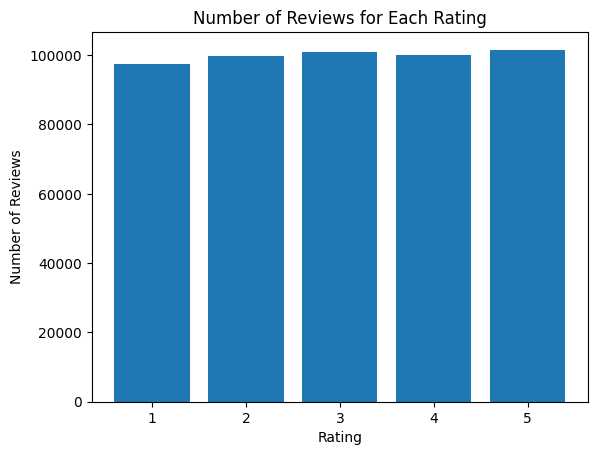

In [19]:
plt.bar(ratings, counts)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Rating')
plt.show()

In [20]:
df = df.toPandas()

/tmp/ipykernel_42/2378651584.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [21]:
spark.stop()

In [22]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

# Model

In [23]:

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [24]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, dataframe, block_size=128,max_length=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.block_size = block_size
        self.max_length = max_length


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['processed_text'])
        label = torch.tensor(int(self.data.iloc[idx]['class_index']) - 1, dtype=torch.long)
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'labels': label,
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [30]:
train_dataset = CustomDataset(tokenizer, df_train)
valid_dataset = CustomDataset(tokenizer, df_valid)

In [31]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [32]:
training_args = TrainingArguments(
    output_dir="./amazon_model",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=2,
    do_eval=True,
    evaluation_strategy='epoch',
    save_steps = 50000
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,

)


In [34]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.996400,1.007300,0.570551


TrainOutput(global_step=79999, training_loss=1.104085050452779, metrics={'train_runtime': 9608.9281, 'train_samples_per_second': 41.627, 'train_steps_per_second': 8.325, 'total_flos': 2.631128801011507e+16, 'train_loss': 1.104085050452779, 'epoch': 1.0})

In [35]:
trainer.save_model()

In [36]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [37]:
zip_dir()

/kaggle/working/directory.zip

# Test data

In [113]:
import pandas as pd

In [114]:
df_test=pd.read_csv("/kaggle/input/amazon-reviews-bigdata/test.csv")

In [115]:
df_test

,class_index,review_title,review_text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."
...,...,...,...
649995,5,Pretty Cool!,We got it for our mom's birthday. She LOVES it...
649996,5,great cd,"this cd is very good. i especially love ""cats ..."
649997,2,An interesting look into Boston's comedy clubs,This was a good documentary on the history of ...
649998,5,Du vol...pour les cowboys!,Avez-vous déjà vu un CD double et un DVD avec ...


In [116]:
def preprocess(row):
    review_title = row["review_title"] if pd.notna(row["review_title"]) else ""
    review_text = row["review_text"] if pd.notna(row["review_text"]) else ""

    text = f"{review_title} [SEP] {review_text}" if review_title or review_text else ""

    text = text.lower()

    if text:
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()

        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    return text


In [117]:
df_test["processed_text"] = df_test.apply(preprocess, axis=1)

/tmp/ipykernel_42/1795872905.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [118]:
df_test

,class_index,review_title,review_text,processed_text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ...",mens ultrasheer sep this model may be ok for s...
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...,surprisingly delightful sep this is a fast rea...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...,works but not as advertised sep i bought one o...
3,2,Oh dear,I was excited to find a book ostensibly about ...,oh dear sep i was excited to find a book osten...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod...",incorrect disc sep i am a big jvc fan but i do...
...,...,...,...,...
649995,5,Pretty Cool!,We got it for our mom's birthday. She LOVES it...,pretty cool sep we got it for our moms birthda...
649996,5,great cd,"this cd is very good. i especially love ""cats ...",great cd sep this cd is very good i especially...
649997,2,An interesting look into Boston's comedy clubs,This was a good documentary on the history of ...,an interesting look into bostons comedy clubs ...
649998,5,Du vol...pour les cowboys!,Avez-vous déjà vu un CD double et un DVD avec ...,du volpour les cowboys sep avezvous dj vu un c...


In [128]:
class TestCustomDataset(Dataset):
    def __init__(self, tokenizer, dataframe, block_size=128,max_length=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.block_size = block_size
        self.max_length = max_length


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx])
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [129]:
test_dataset = TestCustomDataset(tokenizer, df_test["processed_text"])


In [133]:
predictions=trainer.predict(test_dataset)

In [149]:
predicted_rating=np.argmax(predictions[0], axis=1)

In [150]:
predicted_rating

array([2, 4, 2, ..., 1, 3, 3])

In [153]:
predicted_rating= (predicted_rating)+1

In [154]:
predicted_rating

array([3, 5, 3, ..., 2, 4, 4])

In [155]:
df_test["predicted_rating"]=predicted_rating.tolist()

In [156]:
df_test.head(10)

,class_index,review_title,review_text,processed_text,predicted_rating
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ...",mens ultrasheer sep this model may be ok for s...,3
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...,surprisingly delightful sep this is a fast rea...,5
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...,works but not as advertised sep i bought one o...,3
3,2,Oh dear,I was excited to find a book ostensibly about ...,oh dear sep i was excited to find a book osten...,2
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod...",incorrect disc sep i am a big jvc fan but i do...,2
5,2,Incorrect Disc,"I love the style of this, but after a couple y...",incorrect disc sep i love the style of this bu...,2
6,2,DVD menu select problems,I cannot scroll through a DVD menu that is set...,dvd menu select problems sep i cannot scroll t...,2
7,3,My 2 y/o grandson loves it!!,This movie with all of its animals really keep...,my yo grandson loves it sep this movie with a...,5
8,5,A Cookbook Every Baker Should Own,I found a copy of this cookbook at a local use...,a cookbook every baker should own sep i found ...,5
9,3,good basic,"The book is a basic ""how to"" book for using so...",good basic sep the book is a basic how to book...,3


In [157]:
accuracy = (accuracy_score(df_test["class_index"], df_test["predicted_rating"]))*100

In [158]:
accuracy

57.91369230769231

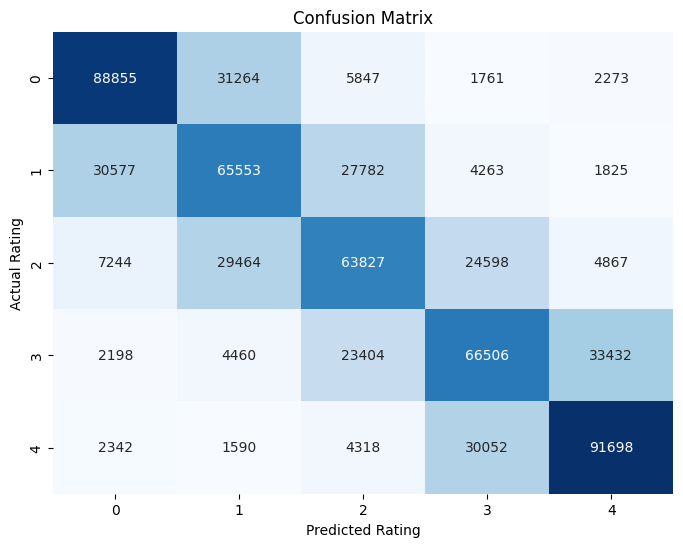

In [161]:
conf_matrix = confusion_matrix(df_test["class_index"], df_test["predicted_rating"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Confusion Matrix')
plt.show()

In [162]:
accuracies = [conf_matrix[i, i] / conf_matrix[i, :].sum() for i in range(conf_matrix.shape[0])]

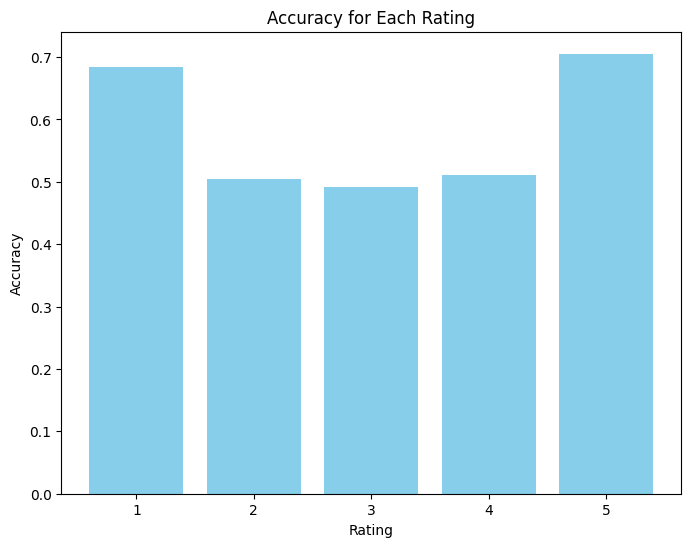

In [163]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Rating')
plt.xticks(range(1, len(accuracies) + 1))
plt.show()